In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import BayesianRidge, HuberRegressor, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data

train = pd.read_csv('df - train_set.csv')
test = pd.read_csv('df - test_set.csv')

train = train[(train['Commodities'] == 'APPLE GOLDEN DELICIOUS')]
del train['Commodities'] 
del test['Commodities']

train.head()

Province Container Size_Grade  Weight_Kg        Date  \
1                   CAPE     M4183         1L       18.3  2020-09-09   
7                   CAPE     JG110         2M       11.0  2020-04-14   
24  W.CAPE-BERGRIVER ETC     JE090         2S        9.0  2020-04-16   
40                  CAPE     M4183         1S       18.3  2020-05-04   
69          EASTERN CAPE     IA400         1S      400.0  2020-09-28   

    Low_Price  High_Price  Sales_Total  Total_Qty_Sold  Total_Kg_Sold  \
1       150.0       170.0      51710.0             332         6075.6   
7        50.0        50.0      16000.0             320         3520.0   
24       55.0        55.0        990.0              18          162.0   
40       80.0       120.0      32020.0             388         7100.4   
69     1800.0      1800.0       1800.0               1          400.0   

    Stock_On_Hand  avg_price_per_kg  
1             822              8.51  
7               0              4.55  
24           1506              6.11  
40            443              4.51  
69              2              4.50

In [7]:
train.shape

(1952, 12)

In [8]:
test.head()

Index              Province Container Size_Grade  Weight_Kg        Date  \
0      1  W.CAPE-BERGRIVER ETC     EC120         1M       12.0  2020-07-09   
1      2  W.CAPE-BERGRIVER ETC     M4183         1X       18.3  2020-01-20   
2      3  W.CAPE-BERGRIVER ETC     EC120         1S       12.0  2020-08-19   
3      4  W.CAPE-BERGRIVER ETC     M4183         1M       18.3  2020-05-06   
4      5  W.CAPE-BERGRIVER ETC     M4183         1L       18.3  2020-05-04   

   Low_Price  High_Price  Sales_Total  Total_Qty_Sold  Total_Kg_Sold  \
0      128.0       136.0       5008.0              38          456.0   
1      220.0       220.0       1760.0               8          146.4   
2      120.0       120.0        720.0               6           72.0   
3      160.0       160.0        160.0               1           18.3   
4      140.0       160.0      14140.0             100         1830.0   

   Stock_On_Hand  
0              0  
1              2  
2             45  
3              8  
4             19

In [9]:
# getting info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Date              1952 non-null   object 
 5   Low_Price         1952 non-null   float64
 6   High_Price        1952 non-null   float64
 7   Sales_Total       1952 non-null   float64
 8   Total_Qty_Sold    1952 non-null   int64  
 9   Total_Kg_Sold     1952 non-null   float64
 10  Stock_On_Hand     1952 non-null   int64  
 11  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 198.2+ KB


In [7]:
train['Province'].unique()

array(['CAPE', 'W.CAPE-BERGRIVER ETC', 'EASTERN CAPE', 'NATAL',
       'WEST COAST', 'TRANSVAAL', 'ORANGE FREE STATE'], dtype=object)

In [8]:
train['Container'].unique()

array(['M4183', 'JG110', 'JE090', 'IA400', 'EC120', 'AC030', 'M6125',
       'EF120', 'DT063', 'M9125', 'EG140'], dtype=object)

In [9]:
train['Size_Grade'].unique()

array(['1L', '2M', '2S', '1S', '1M', '1X', '2L', '2U', '2X', '1U'],
      dtype=object)

In [10]:
train.describe()

Weight_Kg    Low_Price   High_Price    Sales_Total  Total_Qty_Sold  \
count  1952.000000  1952.000000  1952.000000    1952.000000     1952.000000   
mean     40.460912   174.307377   215.648053   20053.533811      174.510758   
std      99.655169   373.553578   433.546159   39005.069445      308.810797   
min       3.000000     2.000000     5.000000       5.000000        1.000000   
25%       9.000000    50.000000    60.000000    1325.000000       12.000000   
50%      12.000000    80.000000   108.000000    5495.000000       64.000000   
75%      18.300000   127.250000   160.000000   21082.500000      200.000000   
max     400.000000  2300.000000  3300.000000  369464.000000     4237.000000   

       Total_Kg_Sold  Stock_On_Hand  avg_price_per_kg  
count    1952.000000    1952.000000       1952.000000  
mean     2960.176332     408.393955          6.778893  
std      6097.416527     724.450582          2.248744  
min         3.000000       0.000000          0.250000  
25%       219.600000       9.000000          5.460000  
50%       853.500000     126.500000          6.670000  
75%      3093.525000     468.000000          8.280000  
max     74000.000000    6400.000000         21.240000

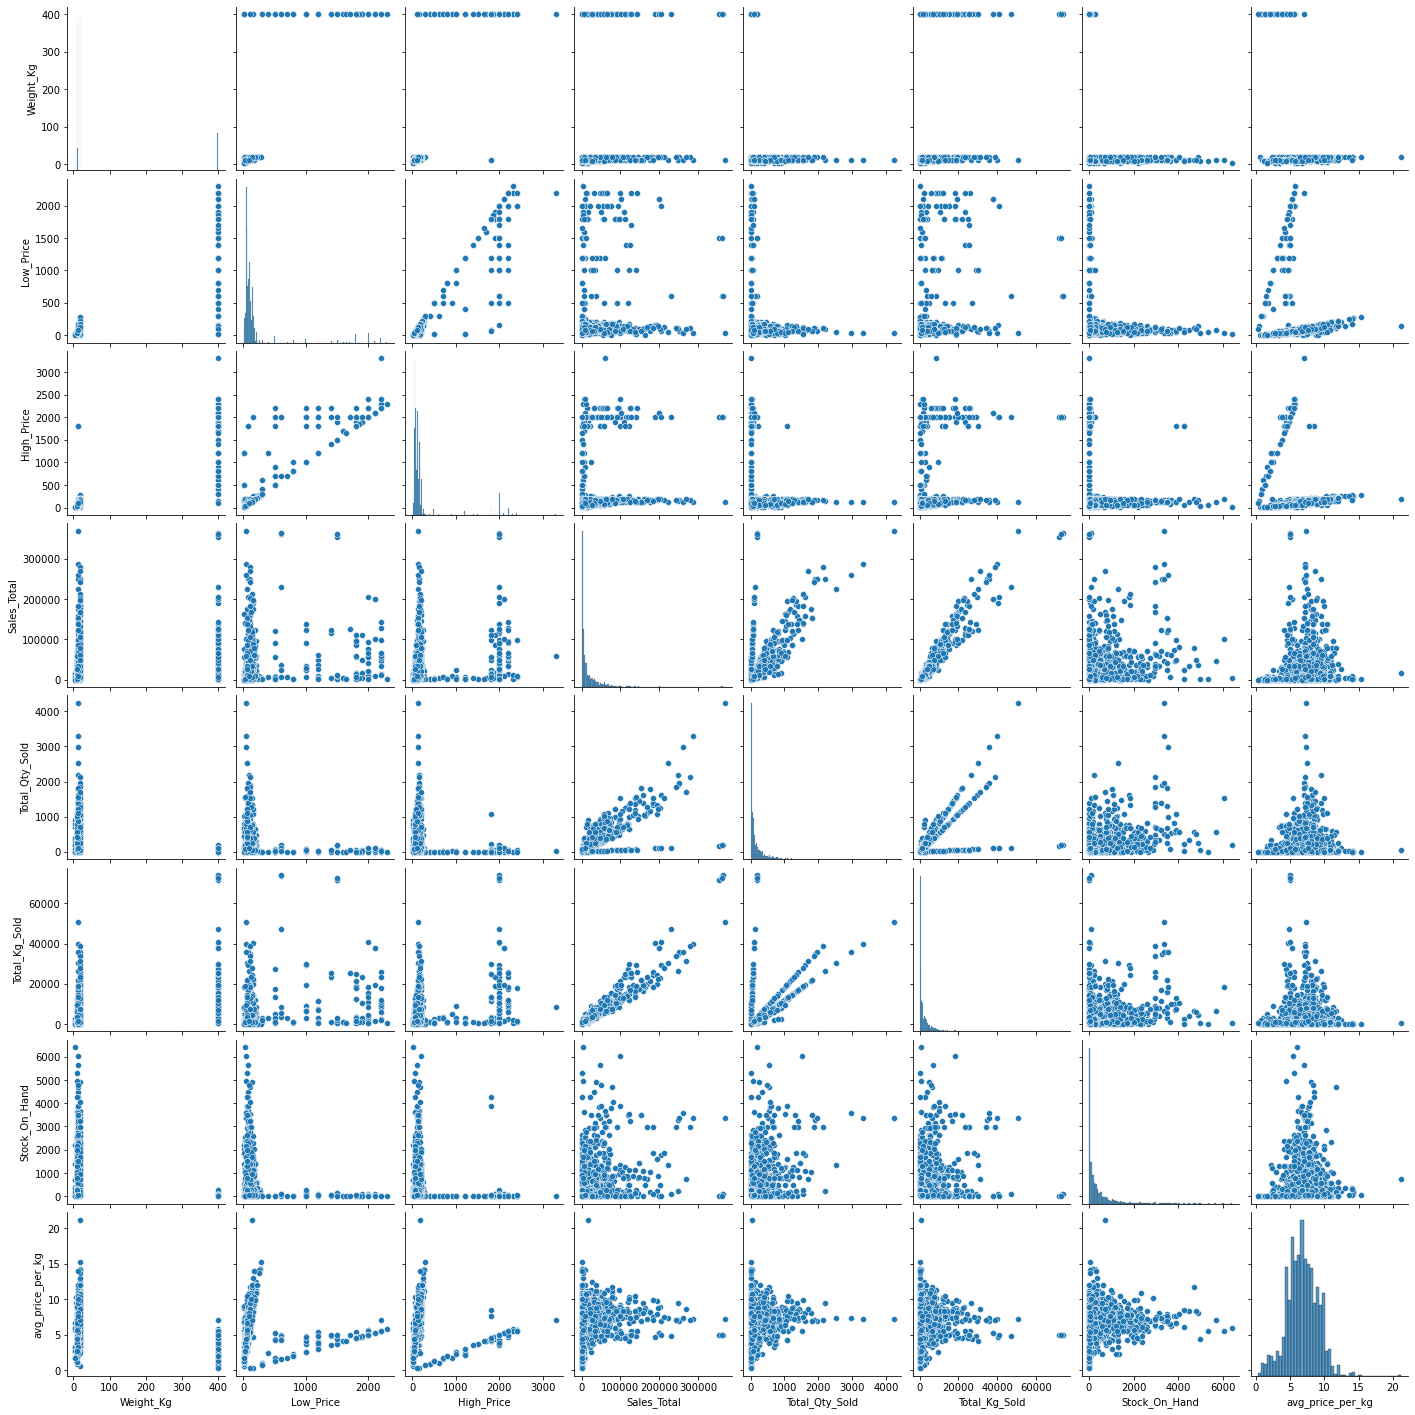

In [9]:
#using pair plot to understand the  distribution with each otherr

sns.pairplot(train)

<AxesSubplot:>

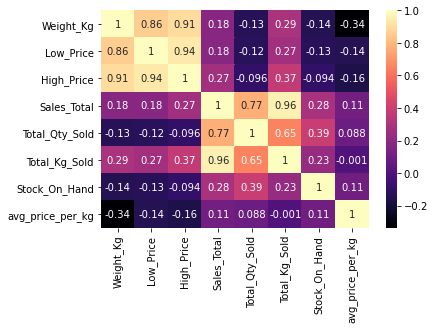

In [10]:
#heatmap to understand the correlation with each other

sns.heatmap(train.corr(),annot =True,cmap='magma')

According to the above correlation matrix Low price, High price, Sales total, total kg sold are highly correlated. Which is why we are going to drop them in model selection. This is done because Highly correlated variables will cuase the model to be biased towards them.

Understanding the distribution of our target 


C:\Users\Daniel\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

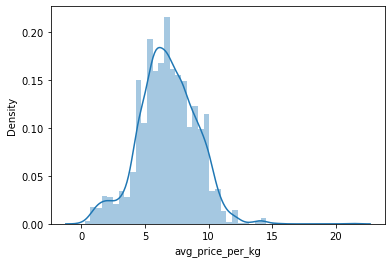

In [11]:
sns.distplot(train['avg_price_per_kg'],kde =True)

In [12]:
#add a note about how its distributed

In [13]:
#here goes feature engineering make more research on it, we are going to be left with province,
#container, size grade, weight kg, stock on hand and date, total qty sold.
#I think FE is about making plots about the variables in relation to each other

In [5]:
# DUMMY

def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [8]:
# PREPROCESSING 
seed = 1
def preprocess_inputs(df, return_df=False):
    df = df.copy()
    
    # CLEAN PROVINCE COLUMN
    
    df['Province'] = df['Province'].str.replace(' ', '_')
    df['Province'] = df['Province'].str.replace('.', '_')
    df['Province'] = df['Province'].str.replace('-', '_')
    
    # DATE ENCODING
    # Split 'Date' column into year, month and day columns 

    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime('%d.%m.%Y')
    df['year'] = pd.DatetimeIndex(df['Date']).year
    df['month'] = pd.DatetimeIndex(df['Date']).month
    df['day'] = pd.DatetimeIndex(df['Date']).day

    df = df.drop(['Date'], axis = 1) 
    
    # BINARY ENCODING
    
    df['year'] = df['year'].replace({2020: 1, 2019: 0})
        
    # ONE-HOT ENCODING
    for column in ['Province', 'Container']:
        df = onehot_encode(df, column)
        
    # ORDINAL ENCODING
    enc = OrdinalEncoder()
    df[['Size_Grade']] = enc.fit_transform(df[['Size_Grade']]) 
   
        
    if return_df==True:
        return df

    ## for training dataset
        # REORDER COLUMNS SO THAT OUR DEPENDENT VARIABLE IS THE LAST COLUMN OF THE DATAFRAME
    elif 'avg_price_per_kg' in df.columns:
        column_titles = [col for col in df.columns if col!= 'avg_price_per_kg'] + ['avg_price_per_kg']
        df = df.reindex(columns = column_titles)
    
        # SPLIT DATA INTO PREDICTORS AND TARGET
    
        y = df['avg_price_per_kg']
        X = df.drop('avg_price_per_kg', axis=1)
        y = np.array(y)
        

        # TRAIN TEST SPLIT
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=seed)
        
        return X_train, X_test, y_train, y_test
    
        
    else:
        return df
    

In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(train)

In [10]:
# TRAIN A FEW MODELS

models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization)": Ridge(),
    " Linear Regression (L1 Regularization)": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(n_estimators= 400, random_state= seed),
    "                     Gradient Boosting": GradientBoostingRegressor(),
    "                               XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=400),
    "                         BayesianRidge": BayesianRidge(),
    "                        HuberRegressor": HuberRegressor(),
    "                     CatBoostRegressor": CatBoostRegressor(verbose=0),
    "             OrthogonalMatchingPursuit": OrthogonalMatchingPursuit()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
 Linear Regression (L2 Regularization) trained.
 Linear Regression (L1 Regularization) trained.
                   K-Nearest Neighbors trained.
                        Neural Network trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                         Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                         BayesianRidge trained.
                        HuberRegressor trained.
                     CatBoostRegressor trained.
             OrthogonalMatchingPursuit trained.


In [13]:
#EVALUATE MODEL ON R SQUARED - HIGHER IS BETTER

for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_test, y_test)))
    

                     Linear Regression R^2 Score: 0.57379
 Linear Regression (L2 Regularization) R^2 Score: 0.57362
 Linear Regression (L1 Regularization) R^2 Score: 0.39859
                   K-Nearest Neighbors R^2 Score: 0.81609
                        Neural Network R^2 Score: -7.49320
Support Vector Machine (Linear Kernel) R^2 Score: -172.82428
   Support Vector Machine (RBF Kernel) R^2 Score: 0.20561
                         Decision Tree R^2 Score: 0.93471
                         Random Forest R^2 Score: 0.95214
                     Gradient Boosting R^2 Score: 0.93123
                               XGBoost R^2 Score: 0.96178
                         BayesianRidge R^2 Score: 0.57295
                        HuberRegressor R^2 Score: -2.67206
                     CatBoostRegressor R^2 Score: 0.94183
             OrthogonalMatchingPursuit R^2 Score: 0.34119


In [12]:
#EVALUATE MODEL ON RMSE - LOWER IS BETTER

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name + " RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_test ,y_pred))))
    
    errors = abs(y_pred - y_test)

    # Display the performance metrics
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    mape = np.mean(100 * (errors / y_test))
    accuracy = 100 - mape

    print('Accuracy:', round(accuracy, 2), '%.')

                     Linear Regression RMSE: 1.50874
Mean Absolute Error: 1.13 degrees.
Accuracy: 74.38 %.
 Linear Regression (L2 Regularization) RMSE: 1.50904
Mean Absolute Error: 1.13 degrees.
Accuracy: 74.32 %.
 Linear Regression (L1 Regularization) RMSE: 1.79221
Mean Absolute Error: 1.31 degrees.
Accuracy: 69.01 %.
                   K-Nearest Neighbors RMSE: 0.99107
Mean Absolute Error: 0.72 degrees.
Accuracy: 86.34 %.
                        Neural Network RMSE: 6.73500
Mean Absolute Error: 4.27 degrees.
Accuracy: -5.61 %.
Support Vector Machine (Linear Kernel) RMSE: 30.46894
Mean Absolute Error: 10.55 degrees.
Accuracy: -124.53 %.
   Support Vector Machine (RBF Kernel) RMSE: 2.05978
Mean Absolute Error: 1.54 degrees.
Accuracy: 58.6 %.
                         Decision Tree RMSE: 0.59051
Mean Absolute Error: 0.3 degrees.
Accuracy: 94.75 %.
                         Random Forest RMSE: 0.50556
Mean Absolute Error: 0.28 degrees.
Accuracy: 94.29 %.
                     Gradient Boost

In [35]:
# GENERATE CSV FOR SUBMISSION TO KAGGLE
# DON'T SUBMIT ALL, ONLY THOSE WHICH DID GOOD ON EVALUATION TO CONFIRM

df = preprocess_inputs(test)

Xs = list(df.columns)
Xs.remove('Index')

X_test = df[Xs]


for name, model in models.items():
    y_pred = model.predict(X_scaled)

    d = pd.DataFrame(y_pred, columns =['avg_price_per_kg'])
    dff = pd.concat([df['Index'], d], axis=1)
    dff = dff.set_index('Index')
    
    match= re.findall('[A-Z]', name)    
    matchno = re.findall('[0-9]+', name)   
    file_name = ''.join(match) + ''.join(matchno)
    if file_name == 'XGB':
        dff.to_csv(file_name + '.csv')

In [15]:
# NOW TRY ENSEMBLE STACKING

# CHOOSE BEST MODELS FROM EARLIER SCORES


rf = RandomForestRegressor(n_estimators= 400, random_state= seed)
gb =GradientBoostingRegressor(random_state= seed)
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=400, random_state= seed)
cb= CatBoostRegressor(verbose=0)
dt = DecisionTreeRegressor(random_state= seed)

meta_learner_reg = CatBoostRegressor(verbose=0)


models = [("rf", rf),("gb", gb),("xgb", xgb), ('cb', cb), ('dt', dt)]

s_reg = StackingRegressor(estimators=models, final_estimator= meta_learner_reg)


In [16]:
X_train, X_test, y_train, y_test = preprocess_inputs(train)

s_reg.fit(X_train,y_train)
print("Stacked model fitted.")

Stacked model fitted.


In [17]:
# METRICS OF STACKING REGRESSOR

y_pred = s_reg.predict(X_test)
rsq = s_reg.score(X_test, y_test)
print("R^2 Score: ", rsq)

print("RMSE: {:.5f}".format(np.sqrt(metrics.mean_squared_error(y_test ,y_pred))))
 
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

R^2 Score:  0.9595363438993292
RMSE: 0.46487
Mean Absolute Error: 0.28 degrees.
Accuracy: 94.71 %.


In [ ]:
# SAVING STACKED REGRESSOR PREDICTIONS TO CSV

df = preprocess_inputs(test)
Xs = list(df.columns)
Xs.remove('Index')

X_test = df[Xs]

y_pred = s_reg.predict(X_test)
d = pd.DataFrame(y_pred, columns =['avg_price_per_kg'])
dff = pd.concat([df['Index'], d], axis=1)
dff = dff.set_index('Index')
dff.to_csv('Stacked.csv')